# Using stable water isotopes for 2-component mass balance hydrograph separation

Warning message:
“ 3 failed to parse.”


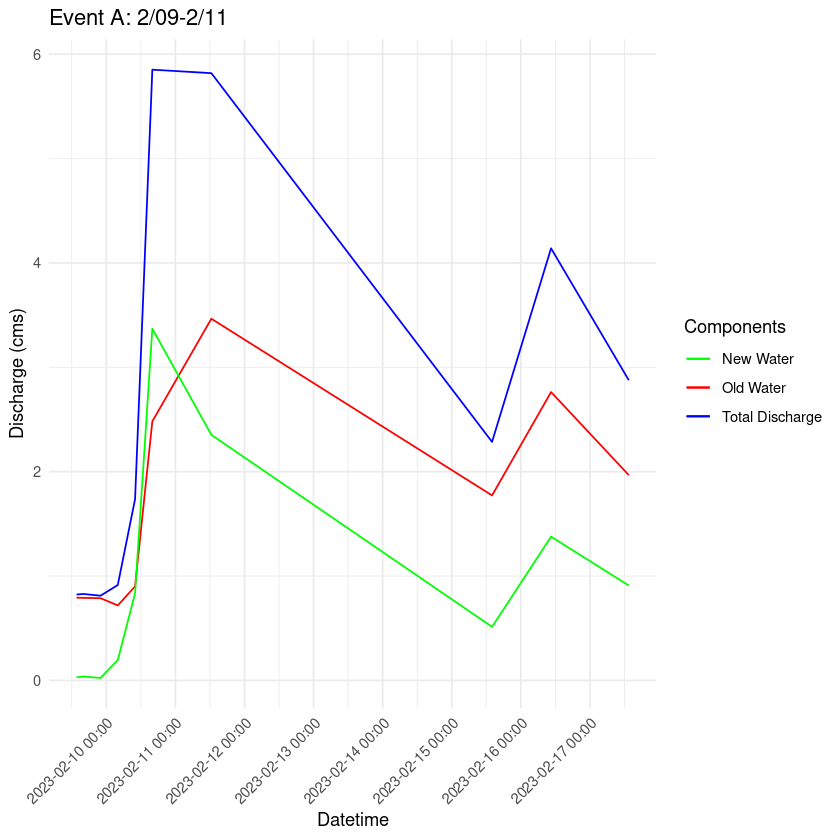

[[1]]

[[2]]

[[3]]


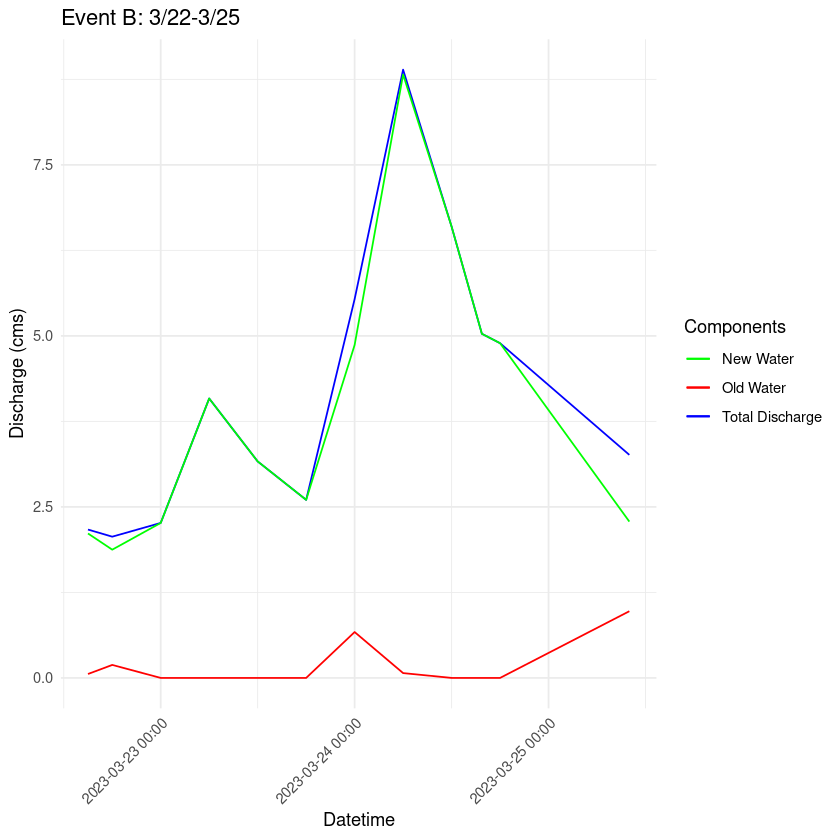

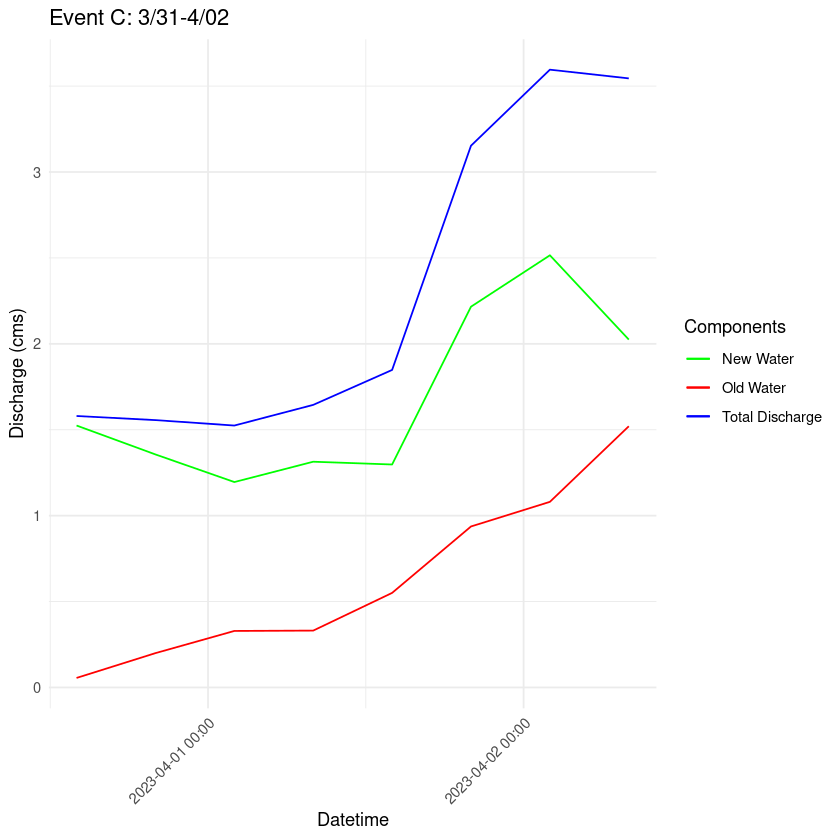

In [27]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

setwd("~//OneDrive/git-repos/EMMA/")

input_dir <- "isco_metadata/LCBP_RI_sample_index/"
output_dir <- "isotope-separation/output"
q_input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/"

#################
# SET SITE INFO #
#################

site = "Hungerford"
Year = "WY23"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputDataISCO <- read.csv(file.path(input_dir, "RI23-isotope-joined.csv"))

# read in the discharge data
InputDataQ <- read.csv(file.path(q_input_dir, "hb_q_chem copy.csv")) %>%
    rename(q_cms = q_cms_hb)
 

########################
# CLEAN AND JOIN DATA  #
########################

# Convert missing values to NA
InputDataISCO[InputDataISCO == ""] <- NA

# Combine 'Date' and 'Time' columns into 'Datetime' 
InputDataISCO$Datetime <- mdy_hm(paste(InputDataISCO$Date, InputDataISCO$Time)) 

# Convert 'datetime' in InputDataQ to proper datetime format
InputDataQ$datetime <- as.POSIXct(InputDataQ$datetime, format="%Y-%m-%dT%H:%M:%SZ")

# Convert dataframes to data.table
InputDataISCO_DT <- as.data.table(InputDataISCO)
InputDataQ_DT <- as.data.table(InputDataQ)

# Set keys for joining
setkey(InputDataISCO_DT, Datetime)
setkey(InputDataQ_DT, datetime)

# Perform a nearest join using data.table
merged_data <- InputDataQ_DT[InputDataISCO_DT, roll = "nearest", on = .(datetime = Datetime)]

###################
# FILTER THE DATA #
###################

InputDataStream <- merged_data %>%
    filter(Site == site) %>%
    filter(!is.na(datetime)) %>%
    filter(Type2 == 'Stream')

InputDataEM <- merged_data %>%
    filter(Site == site) %>%
    filter(!is.na(datetime)) %>%
    filter(Type2 == 'Endmember')

########################
# SEPARATE INTO EVENTS #
########################

# Make sure date formatting all good
InputDataStream$Date <- as.Date(InputDataStream$datetime) # Assuming Datetime is in POSIXct format
InputDataEM$Date <- as.Date(InputDataEM$datetime) # Assuming Datetime is in POSIXct format

# Add Event column based on date ranges
InputDataStream <- InputDataStream %>%
  mutate(Event = case_when(
    Date >= as.Date('2023-02-08') & Date <= as.Date('2023-02-20') ~ 'Event A: 2/09-2/11',
    Date >= as.Date('2023-03-21') & Date <= as.Date('2023-03-25') ~ 'Event B: 3/22-3/25',
    Date >= as.Date('2023-03-30') & Date <= as.Date('2023-04-02') ~ 'Event C: 3/31-4/02',
    #Date >= as.Date('2023-03-31') & Date <= as.Date('2023-04-02') ~ 'Event D: 4/02-4/12',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Filter out rows where Event is NA
InputDataStream <- InputDataStream %>%
  filter(!is.na(Event))

# Nest data by Event
nested_data <- InputDataStream %>%
  group_by(Event) %>%
  nest

#####################
# DO IMB SEPARATION #
#####################

# Create a function to calculate new and old water proportions and plot the hydrograph
process_event <- function(data, event_name, InputDataEM) {
  # Set new and old water values based on the event
  if (event_name == "Event A: 2/09-2/11") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snowmelt lysimeter" & Date == as.Date('2023-02-15')) %>%
      pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Baseflow" & Date == as.Date('2023-01-24')) %>%
      pull(d18O)
  } else if (event_name == "Event B: 3/22-3/25") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snowmelt lysimeter" & Date == as.Date('2023-03-28')) %>%
      pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Baseflow" & Date == as.Date('2023-01-24')) %>%
      pull(d18O)
  } else if (event_name == "Event C: 3/31-4/02") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snowmelt lysimeter" & Date == as.Date('2023-03-28')) %>%
      pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Baseflow" & Date == as.Date('2023-01-24')) %>%
      pull(d18O)
  } else {
    stop("Unknown event")
  }

# Calculate Q_o(t) using Equation 3 and ensure it is non-negative
  data <- data %>%
  mutate(Q_o = pmax(`q_cms` * (`d18O` - Event_new) / (Event_old - Event_new), 0),
         Q_n = pmax(`q_cms` - Q_o, 0))
 
#########################################
# Plot using ggplot2 (part of function) #
#########################################
    
  hydrograph_plot <- ggplot(data, aes(x = datetime)) +
    geom_line(aes(y = q_cms, color = "Total Discharge")) +
    geom_line(aes(y = Q_o, color = "Old Water")) +
    geom_line(aes(y = Q_n, color = "New Water")) +
    scale_color_manual(values = c("Total Discharge" = "blue", "Old Water" = "red", "New Water" = "green")) +
    theme_minimal() +
    labs(title = event_name,
         x = "Datetime",
         y = "Discharge (cms)",
         color = "Components") +
    scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 day") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  # Save the plot to a file
  #ggsave(file.path(output_dir, paste0("storm_hydrograph_", gsub("[: ]", "_", event_name), ".png")), hydrograph_plot, width = 10, height = 6)
  
  return(hydrograph_plot)
}

# Apply the function to each event
plots <- nested_data %>%
  mutate(plot = map2(data, Event, ~ process_event(.x, .y, InputDataEM)))

# Print all plots 
# Uncomment to print single event plots
plots$plot

Warning message:
“ 3 failed to parse.”


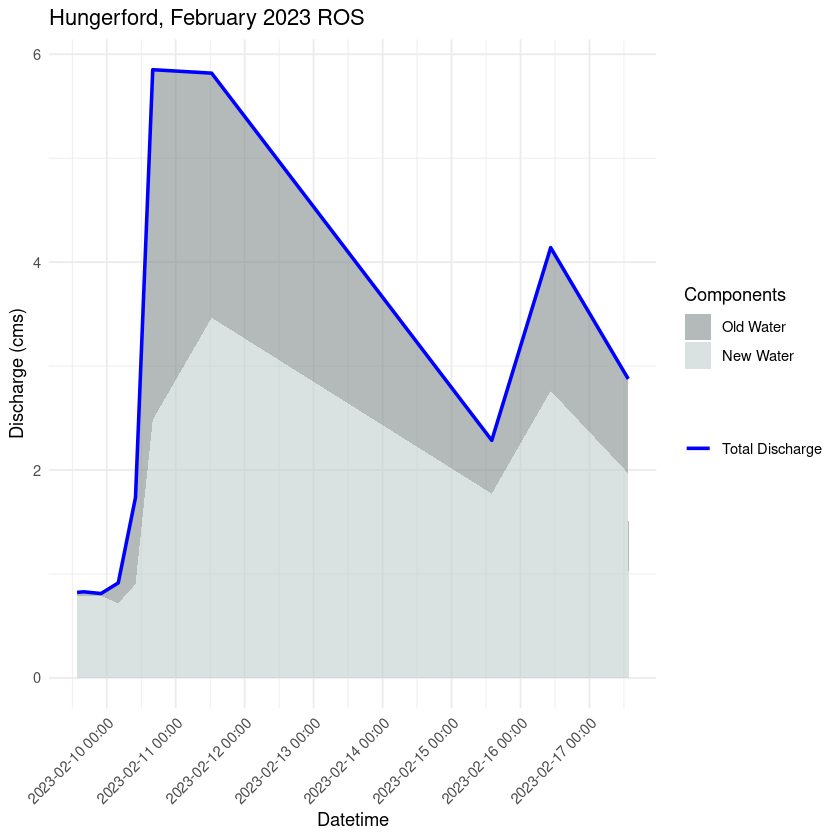

[[1]]

[[2]]

[[3]]


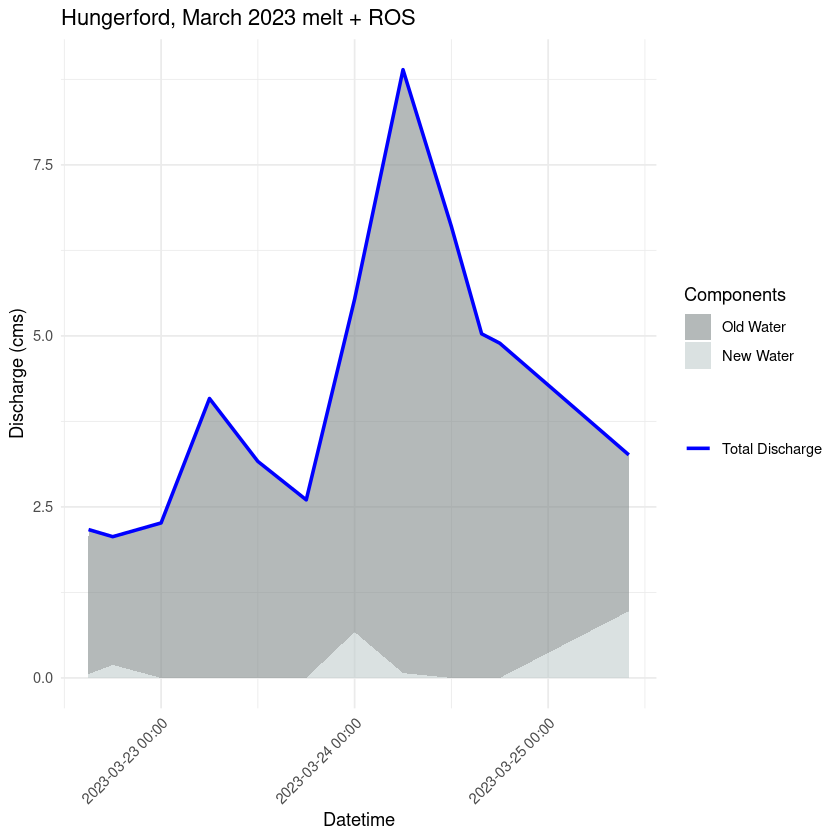

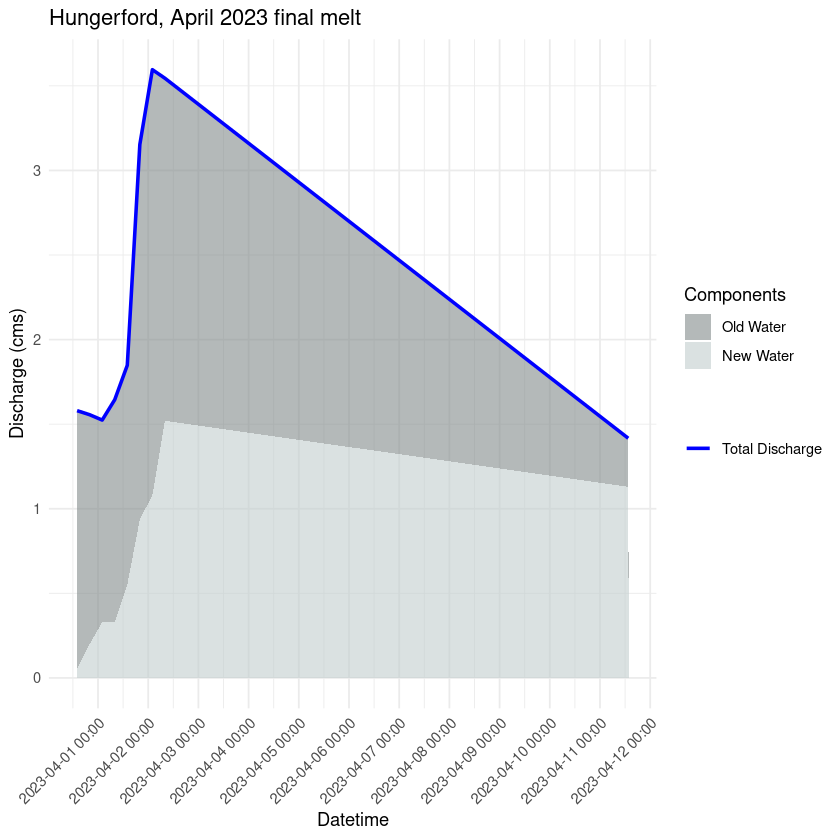

In [42]:
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(ggplot2)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

setwd("~//OneDrive/git-repos/EMMA/")

input_dir <- "isco_metadata/LCBP_RI_sample_index/"
output_dir <- "isotope-separation/output"
q_input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/"

#################
# SET SITE INFO #
#################

site = "Hungerford"
Year = "WY23"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputDataISCO <- read.csv(file.path(input_dir, "RI23-isotope-joined.csv"))

# read in the discharge data
InputDataQ <- read.csv(file.path(q_input_dir, "hb_q_chem copy.csv")) %>%
    rename(q_cms = q_cms_hb)
 

########################
# CLEAN AND JOIN DATA  #
########################

# Convert missing values to NA
InputDataISCO[InputDataISCO == ""] <- NA

# Combine 'Date' and 'Time' columns into 'Datetime' 
InputDataISCO$Datetime <- mdy_hm(paste(InputDataISCO$Date, InputDataISCO$Time)) 

# Convert 'datetime' in InputDataQ to proper datetime format
InputDataQ$datetime <- as.POSIXct(InputDataQ$datetime, format="%Y-%m-%dT%H:%M:%SZ")

# Convert dataframes to data.table
InputDataISCO_DT <- as.data.table(InputDataISCO)
InputDataQ_DT <- as.data.table(InputDataQ)

# Set keys for joining
setkey(InputDataISCO_DT, Datetime)
setkey(InputDataQ_DT, datetime)

# Perform a nearest join using data.table
merged_data <- InputDataQ_DT[InputDataISCO_DT, roll = "nearest", on = .(datetime = Datetime)]

###################
# FILTER THE DATA #
###################

InputDataStream <- merged_data %>%
    filter(Site == site) %>%
    filter(!is.na(datetime)) %>%
    filter(Type2 == 'Stream')

InputDataEM <- merged_data %>%
    filter(Site == site) %>%
    filter(!is.na(datetime)) %>%
    filter(Type2 == 'Endmember')

########################
# SEPARATE INTO EVENTS #
########################

# Make sure date formatting all good
InputDataStream$Date <- as.Date(InputDataStream$datetime) # Assuming Datetime is in POSIXct format
InputDataEM$Date <- as.Date(InputDataEM$datetime) # Assuming Datetime is in POSIXct format

# Add Event column based on date ranges
InputDataStream <- InputDataStream %>%
  mutate(Event = case_when(
    Date >= as.Date('2023-02-08') & Date <= as.Date('2023-02-20') ~ 'Hungerford, February 2023 ROS',
    Date >= as.Date('2023-03-21') & Date <= as.Date('2023-03-26') ~ 'Hungerford, March 2023 melt + ROS',
    Date >= as.Date('2023-03-30') & Date <= as.Date('2023-04-12') ~ 'Hungerford, April 2023 final melt',
    #Date >= as.Date('2023-03-31') & Date <= as.Date('2023-04-02') ~ 'Event D: 4/02-4/12',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Filter out rows where Event is NA
InputDataStream <- InputDataStream %>%
  filter(!is.na(Event))

# Nest data by Event
nested_data <- InputDataStream %>%
  group_by(Event) %>%
  nest

#####################
# DO IMB SEPARATION #
#####################

# Create a function to calculate new and old water proportions and plot the hydrograph
process_event <- function(data, event_name, InputDataEM) {
  # Set new and old water values based on the event
  if (event_name == "Hungerford, February 2023 ROS") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snowmelt lysimeter" & Date == as.Date('2023-02-15')) %>%
      pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Baseflow" & Date == as.Date('2023-01-24')) %>%
      pull(d18O)
  } else if (event_name == "Hungerford, March 2023 melt + ROS") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snowmelt lysimeter" & Date == as.Date('2023-03-28')) %>%
      pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Baseflow" & Date == as.Date('2023-01-24')) %>%
      pull(d18O)
  } else if (event_name == "Hungerford, April 2023 final melt") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snowmelt lysimeter" & Date == as.Date('2023-03-28')) %>%
      pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Baseflow" & Date == as.Date('2023-01-24')) %>%
      pull(d18O)
  } else {
    stop("Unknown event")
  }
  
  # Calculate Q_o(t) and Q_n(t) ensuring non-negativity
  data <- data %>%
    mutate(Q_o = pmax(`q_cms` * (`d18O` - Event_new) / (Event_old - Event_new), 0),
           Q_n = pmax(`q_cms` - Q_o, 0))
  
  # Transform data into long format for ggplot
  data_long <- data %>%
    pivot_longer(cols = c(Q_o, Q_n), names_to = "Component", values_to = "Value")
  
  #########################################
  # Plot using ggplot2 (filled area plot) #
  #########################################
  hydrograph_plot <- ggplot() +
    # Filled area for components
    geom_area(data = data_long, aes(x = datetime, y = Value, fill = Component), alpha = 0.6) +
    # Line for total discharge
    geom_line(data = data, aes(x = datetime, y = q_cms, color = "Total Discharge"), size = 1) +
    scale_fill_manual(values = c("Q_o" = "#C1CDCD", "Q_n" = "#838B8B"), labels = c("Old Water", "New Water")) +
    scale_color_manual(values = c("Total Discharge" = "blue")) +
    theme_minimal() +
    labs(title = event_name,
         x = "Datetime",
         y = "Discharge (cms)",
         fill = "Components",
         color = "") +
    scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 day") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  # Save the plot to a file (optional)
  # ggsave(file.path(output_dir, paste0("storm_hydrograph_", gsub("[: ]", "_", event_name), ".png")), hydrograph_plot, width = 10, height = 6)
  
  return(hydrograph_plot)
}


plots <- nested_data %>%
  mutate(plot = map2(data, Event, ~ process_event(.x, .y, InputDataEM)))

# To print all plots
plots$plot